#Comparing XGBoost with Feed Forward Neural Network
In this notebook I compare the XGBoost (xtreme gradient boosting) algorithm with a neural network made using PyTorch. The models are compared on a fraud detection task with a highly unbalanced dataset. The models are compared on basis of the reciever operating curve (ROC) and the area under its curve. 

<h3>What metric to use</h3>
We will be using the reciever operating characteristic (ROC) to determine the optimal model. The ROC shows the relation of true positives and false positives when adjusting the decision boundary. The decision boundary is what probability the model must predict to specify a sample as a positive sample. A true positive is a sample predicted to be positive (in this case fraudulent) when it truly is. A false positive is a sample predicted to be positive when it's truly negative. The ROC can be summarized in one number called ROC area under the curve (ROCAUC). A perfect ROCAUC is 1. This is when there are no false positive or false negatives. <br>
<img src="https://scikit-learn.org/0.15/_images/plot_roc_0011.png" alt="Picture of ROC" width="400" height="300">
<br>
We are using the ROC because the cost of letting frauds go undetected is great. Also, at the same time, the cost of checking if a transaction is fraudulent or not is low. This means that you would like a model that has a high true positive rate. 


https://www.kaggle.com/mlg-ulb/creditcardfraud

In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np

from google.colab import drive
from collections import Counter
import time


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc, roc_auc_score,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.manifold import TSNE

from xgboost import XGBClassifier

#Why Google colab?
When machine learning models are trained the computer is doing calcualtions on tensors (3D vectors). When you're working with tensors it's a big advantage using GPU instead of the CPU. Using GPU will result in the model being trained much faster. The reason for this is that the GPU specializes in computation with tensors. The main advantage with Google Colab (and perhaps the only one) is that you with ease can set the runtime type to be GPU. 

<br>

For more information, see: 
<ul>
  <li href=https://www.youtube.com/watch?v=_cyVDoyI6NE> https://www.youtube.com/watch?v=_cyVDoyI6NE </ul>

In [ ]:
#Mounting google drive
#I'm working in google colab due to ease of using GPU for performance boost
drive.mount('/content/drive')
#CONTENT_DRIVE = './content/drive'

Mounted at /content/drive


#About the data
The data is collected from a Kaggle competition, see https://www.kaggle.com/mlg-ulb/creditcardfraud. The dataset consists of 248 807 non-fraudulent rows and 492 fraudulet rows. This means that only 0.172% of the data is labeled fraudulent. 
<ul>
<li>There are 30 features and two classes (fraud/non-fraud.)
<li>The features named V1,V2,..,V28 are components from PCA. The PCA is done to anonymize the data.
<li>Time shows seconds elapsed from first transaction in dataset to current transaction.
<li>Amount is the size of the transaction
</ul>

In [ ]:
#importing data and making a dataframe
PATH = "/content/drive/My Drive/fraud-detection/"
file_name = "creditcard.csv"
df = pd.read_csv(PATH+file_name)
#renaming Class to label 
df.rename(columns = {"Class":"label"}, inplace = True)

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
# The labels are heavily skewed - descriptives
print('Non fraudulent transactions ', round(df['label'].value_counts()[0]/len(df) * 100,2), '% of the dataset.',sep="")
print('Fraudulent transactions ', round(df['label'].value_counts()[1]/len(df) * 100,2), '% of the dataset.',sep="")

counter = Counter(df.iloc[:,-1])
print("")
print("# non-fraudulent transactions: "+str(counter[0])+".",sep="")
print("# fraudulent transactions: "+str(counter[1])+".",sep="")
print("# of observations: "+str(len(df.iloc[:,-1]))+".",sep="")

Non fraudulent transactions 99.83% of the dataset.
Fraudulent transactions 0.17% of the dataset.

# non-fraudulent transactions: 284315.
# fraudulent transactions: 492.
# of observations: 284807.


In [ ]:
time = df.Time
def make_one_day(x):
  '''Make the two days into one day. Time is then
  a measure of seconds passed on a given day.'''
  if x > 86400:
    x -= 86400
  return x

#remake time series
time_remake = df.Time.apply(lambda x:make_one_day(x))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


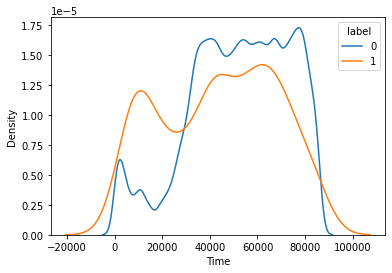

In [ ]:
#plot distribution of label over time
df_plot = pd.merge(df.label, time_remake, left_index=True, right_index=True)
#label = 0 is blue
label_0 = df_plot.loc[df_plot["label"]==0]
#label = 1 is orange
label_1 = df_plot.loc[df_plot["label"]==1]

sns.kdeplot(label_0["Time"], hue=df_plot["label"])
sns.kdeplot(label_1["Time"], hue=df_plot["label"])

In [ ]:
#all features
X = df.iloc[:,1:-1]
X = pd.merge(X, df_plot["Time"], left_index=True, right_index=True)
#labels
y = df.iloc[:,-1]

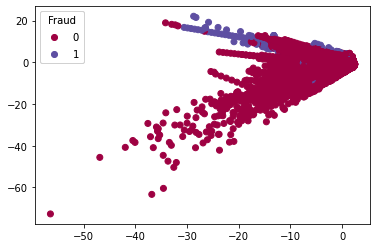

In [ ]:
#plot label 0,1 by V1 and V2 
fig, ax = plt.subplots()
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=y, cmap="Spectral")
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Fraud")
ax.add_artist(legend1)
plt.show()

In [ ]:
#split data in train and test sets
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.1, random_state = 0, stratify = y)

#scaling data for NN
scaler = StandardScaler()
X_train_NN = scaler.fit_transform(X_train)
X_test_NN = scaler.fit_transform(X_test)

In [ ]:
#Check if data was stratified
print(round(sum(y_test)/len(y_test)*100,3))
print(round(sum(y_train)/len(y_train)*100,3))

0.172
0.173


In [ ]:
#make data eligble for pytorch framework

#train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train_NN), 
                       torch.FloatTensor(y_train))

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test_NN))

In [ ]:
#create data iterators
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

#The neural network
In the cell beneath you can see the lay-out of the neural network. It consists of 4 layers: 1 input layer, 2 hidden layers and an output layer. ReLU is applied to each layer except the output layer. Also batch norm is used to speed up the computation. Between layer 2 and layer 3 and layer 3 and the output layer drop out is used. This hinders the network from becomining to dependent on certain nodes in the network. 

<br>

For more information on these topics, see:
<ul>
<li>https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
<li>https://en.wikipedia.org/wiki/Batch_normalization
<li>https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
</ul>

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 30
        # Nodes in first layer = 58
        self.layer_1 = nn.Linear(30, 256) 
        self.layer_2 = nn.Linear(256, 512)
        self.layer_3 = nn.Linear(512,64)
        self.layer_out = nn.Linear(64, 1) 
        
        #use ReLU as act. layer
        self.relu = nn.ReLU()
        #Use droput with keep_prob = 0.9
        self.dropout = nn.Dropout(p=0.1)
        #Use batch normalization
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        #Input sent to linear layer then ReLu is applied
        x = self.relu(self.layer_1(inputs))
        #Normalising before input is passed on
        #batch normalising will make ANN more efficient
        x = self.batchnorm1(x)
        #Input sent to linear layer then ReLu is applied
        x = self.relu(self.layer_2(x))
        #Normalising before input is passed on
        x = self.dropout(x)
        #Zeroes out random parts of input vector
        x = self.batchnorm2(x)
        #linear layer
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        #drop out
        x = self.dropout(x)
        #Last layer
        x = self.layer_out(x)
        
        return x

In [ ]:
#use GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#instantiate model, set loss function (criterion) and optimization model
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

binaryClassification(
  (layer_1): Linear(in_features=30, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#function for calculating prediction accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

The model is trained over 7 epochs, meaning it the iterates the training data 7 times. For each batch, batch size is set to 128, the algorithm minimize the loss function. This is can be thought of as the distance between the output of the model and the true label of the class. The optimization algorithm used is ADAM and the loss is calculated using binary crossentropy with logit loss. 

In [ ]:
#Train model
model.train()
EPOCHS = 50
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #print(X_batch.size())
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.33044 | Acc: 93.925
Epoch 002: | Loss: 0.03348 | Acc: 99.878
Epoch 003: | Loss: 0.00866 | Acc: 99.907
Epoch 004: | Loss: 0.00458 | Acc: 99.913
Epoch 005: | Loss: 0.00321 | Acc: 99.923
Epoch 006: | Loss: 0.00253 | Acc: 99.935
Epoch 007: | Loss: 0.00257 | Acc: 99.933
Epoch 008: | Loss: 0.00205 | Acc: 99.939
Epoch 009: | Loss: 0.00197 | Acc: 99.944
Epoch 010: | Loss: 0.00163 | Acc: 99.948
Epoch 011: | Loss: 0.00156 | Acc: 99.948
Epoch 012: | Loss: 0.00126 | Acc: 99.959
Epoch 013: | Loss: 0.00122 | Acc: 99.954
Epoch 014: | Loss: 0.00110 | Acc: 99.963
Epoch 015: | Loss: 0.00116 | Acc: 99.962
Epoch 016: | Loss: 0.00098 | Acc: 99.967
Epoch 017: | Loss: 0.00104 | Acc: 99.963
Epoch 018: | Loss: 0.00083 | Acc: 99.970
Epoch 019: | Loss: 0.00081 | Acc: 99.970
Epoch 020: | Loss: 0.00088 | Acc: 99.968
Epoch 021: | Loss: 0.00072 | Acc: 99.969
Epoch 022: | Loss: 0.00063 | Acc: 99.974
Epoch 023: | Loss: 0.00061 | Acc: 99.979
Epoch 024: | Loss: 0.00066 | Acc: 99.975
Epoch 025: | Los

#Testing and evaluating the neural network

In [ ]:
#Testing model
y_pred_list = []
y_test_score_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_test_score_list.append(y_test_pred.item())
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

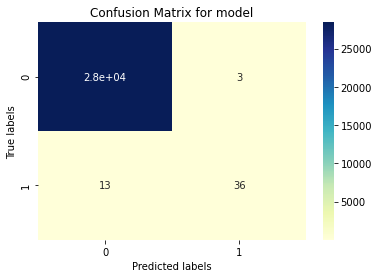

In [ ]:
#make confusion matrix
cm1 = confusion_matrix(y_test, y_pred_list)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, ax = ax, cmap="YlGnBu")
#sns.heatmap(cm1, annot=True, ax = ax, cmap="YlGnBu", norm=colors.LogNorm(vmin=0, vmax=len(y_test))) #<- log scale not working
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for model'); 
#ax.xaxis.set_ticklabels(['Non-fraudulent', 'Fraudulent']); ax.yaxis.set_ticklabels(['Fraudulent', 'Non-fraudulent'])

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test,y_test_score_list)
roc_auc = auc(fpr, tpr)

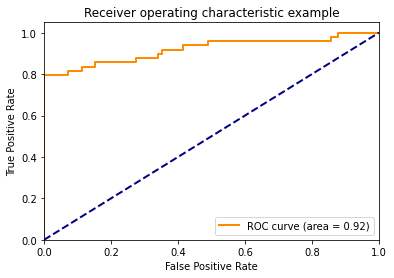

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.88      0.76      0.81        49

    accuracy                           1.00     28481
   macro avg       0.94      0.88      0.91     28481
weighted avg       1.00      1.00      1.00     28481



#The XGBoost model

#Grid search
I'm using randomized grid search. Randomized grid search is a grid search that only tries n different combinations. In this notebook I set n = 20, this means that 20 different models are trained with random combinations of the hyperparameters. 
<br>
The idea is to find a startingpoint for hyperparameter tuning, and then build on from this. As you can see, the hyperparameters are quite spaced out. The hyperparameter codomain is quite stretched. After the first grid search the codomain is shrunk with a mean equal to the best hyperparameter. This is also why the first grid search is called coarse, second is called finer and last one is called finest. 
<br>
In the future I would like to look into different types of hyperparameter optimization, like bayesian hyperparamter optimization, particle swarm, etc. 

In [ ]:
#coarse parameter grid
counter_y = Counter(y_train)
params_coarse ={"learning_rate" : [0.01,0.015,0.02], #size of steps taken at each iteration
                'min_child_weight': [1, 5, 10], #stops splitting nodes when sample is small or certain degree of purity is reached
                'gamma': [0.5, 1, 1.5, 2, 5], #across tree regularization, most important when you have shallow trees
                'subsample': [0.6, 0.8, 1.0], #percantage of sample (size of sub-samples) used to train each tree
                'colsample_bytree': [0.6, 0.8, 1.0], #how many features can be used to train each tree
                'max_depth': [2, 3, 5], #how deep can the tree be
                'scale_pos_weight' : [np.sqrt(counter_y[0]/counter_y[1]),(counter_y[0]/counter_y[1]),1], #ratio between classes; if 90 is neg class, 10 is pos class --> scale_pos_Weight = 9
                'n_estimators' : [100,300,500]
}
#https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
#this are arguments used in the fit of xgboost
fit_params = {
        "early_stopping_rounds" : 10, #if model has not improved in 10 last rounds it stops
        "eval_metric" : "auc", #area under curve; curve being the ROC
        "eval_set": [(X_test,y_test)]
    }

In [ ]:
#instantiate a xgboost model
xgb1 = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)

#K-folds
I'm using stratified k-fold cross validation  in the training of the model. This means the training set is split in k # of folds and a model is trained on k-1 of them, and the last one is used for testing. This is done k times. This is not computational efficient, but it is efficient in use of data. 
<br>
<br>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Picture of ROC" width="400" height="300">
<br>
<br>


In [ ]:
folds = 4 #using 4 folds, slow processing time on my computer
param_comb = 20 #will only do 20 iterations due to processing time

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

#random search checks random combinations of paramters given in parameter grid, with n_iter = 20 it will try 20 random combinations
random_search = RandomizedSearchCV(xgb1, param_distributions=params_coarse, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=0 )

random_search.fit(X_train, y_train, **fit_params)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.2min finished


[0]	validation_0-auc:0.921555
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.925731
[2]	validation_0-auc:0.925364
[3]	validation_0-auc:0.939799
[4]	validation_0-auc:0.940967
[5]	validation_0-auc:0.940099
[6]	validation_0-auc:0.939167
[7]	validation_0-auc:0.933836
[8]	validation_0-auc:0.929106
[9]	validation_0-auc:0.930142
[10]	validation_0-auc:0.928651
[11]	validation_0-auc:0.928157
[12]	validation_0-auc:0.92729
[13]	validation_0-auc:0.943333
[14]	validation_0-auc:0.941598
[15]	validation_0-auc:0.950998
[16]	validation_0-auc:0.951876
[17]	validation_0-auc:0.957732
[18]	validation_0-auc:0.956501
[19]	validation_0-auc:0.95585
[20]	validation_0-auc:0.956096
[21]	validation_0-auc:0.953899
[22]	validation_0-auc:0.953407
[23]	validation_0-auc:0.955585
[24]	validation_0-auc:0.963423
[25]	validation_0-auc:0.964093
[26]	validation_0-auc:0.963823
[27]	validation_0-auc:0.963381
[28]	validation_0-auc:0.963467
[29]	validation_0-auc:0.966049
[30]	validation_0-

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fcc999f6fc0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logisti...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.015, 0.02],
                   

In [ ]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'subsample': 0.6, 'scale_pos_weight': 577.6139954853273, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.8}


In [ ]:
#a finer paramter grid
params_finer ={"learning_rate" : [0.09,0.01,0.011], #size of steps taken at each iteration
              'min_child_weight': [1], #stops splitting nodes when sample is small or certain degree of purity is reached
              'gamma': [ 5, 7, 10], #across tree regularization, most important when you have shallow trees
              'subsample': [0.3,0.45, 0.6], #percantage of sample (size of sub-samples) used to train each tree
              'colsample_bytree': [0.7, 0.8, 0.9], #how many features can be used to train each tree
              'max_depth': [4, 5, 6], #how deep can the tree be
              'scale_pos_weight' : [np.sqrt(counter_y[0]/counter_y[1]),np.sqrt(counter_y[0]/counter_y[1])/2], #ratio between classes; if 90 is neg class, 10 is pos class --> scale_pos_Weight = 9
               'n_estimators' : [500,600,700]
}

In [ ]:
fit_params = {
        "early_stopping_rounds" : 10,
        "eval_metric" : "auc",
        "eval_set": [(X_test,y_test)]
    }

In [ ]:
random_search2 = RandomizedSearchCV(xgb1, param_distributions=params_finer, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=0 )

random_search2.fit(X_train, y_train, **fit_params)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 11.6min finished


[0]	validation_0-auc:0.931474
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.931408
[2]	validation_0-auc:0.931224
[3]	validation_0-auc:0.930958
[4]	validation_0-auc:0.937735
[5]	validation_0-auc:0.935863
[6]	validation_0-auc:0.935385
[7]	validation_0-auc:0.934646
[8]	validation_0-auc:0.934586
[9]	validation_0-auc:0.934117
[10]	validation_0-auc:0.934116
[11]	validation_0-auc:0.934362
[12]	validation_0-auc:0.935123
[13]	validation_0-auc:0.934828
[14]	validation_0-auc:0.934407
Stopping. Best iteration:
[4]	validation_0-auc:0.937735



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fcc9988ffc0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logisti...
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [5, 7, 10],
                                        'learning_rate': [0.09, 0.01, 0.011],
                            

In [ ]:
print('\n Best hyperparameters:')
print(random_search2.best_params_)


 Best hyperparameters:
{'subsample': 0.45, 'scale_pos_weight': 24.03360138400667, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.09, 'gamma': 5, 'colsample_bytree': 0.9}


In [ ]:
finest_params = {"learning_rate" : [0.08,0.09], #size of steps taken at each iteration
              'min_child_weight': [1], #stops splitting nodes when sample is small or certain degree of purity is reached
              'gamma': [ 5], #across tree regularization, most important when you have shallow trees
              'subsample': [0.4,0.45, 0.5], #percantage of sample (size of sub-samples) used to train each tree
              'colsample_bytree': [0.6,0.7], #how many features can be used to train each tree
              'max_depth': [5], #how deep can the tree be
              'scale_pos_weight' : [np.sqrt(counter_y[0]/counter_y[1]),30], #ratio between classes; if 90 is neg class, 10 is pos class --> scale_pos_Weight = 9
               'n_estimators' : [700,800,900]
}

In [ ]:
random_search3 = RandomizedSearchCV(xgb1, param_distributions=params_finer, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=0 )

random_search3.fit(X_train, y_train, **fit_params)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 11.6min finished


[0]	validation_0-auc:0.931474
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.931408
[2]	validation_0-auc:0.931224
[3]	validation_0-auc:0.930958
[4]	validation_0-auc:0.937735
[5]	validation_0-auc:0.935863
[6]	validation_0-auc:0.935385
[7]	validation_0-auc:0.934646
[8]	validation_0-auc:0.934586
[9]	validation_0-auc:0.934117
[10]	validation_0-auc:0.934116
[11]	validation_0-auc:0.934362
[12]	validation_0-auc:0.935123
[13]	validation_0-auc:0.934828
[14]	validation_0-auc:0.934407
Stopping. Best iteration:
[4]	validation_0-auc:0.937735



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fcc999f6e60>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logisti...
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [5, 7, 10],
                                        'learning_rate': [0.09, 0.01, 0.011],
                            

In [ ]:
print('\n Best hyperparameters:')
print(random_search3.best_params_)
print(random_search2.best_params_)


 Best hyperparameters:
{'subsample': 0.45, 'scale_pos_weight': 24.03360138400667, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.09, 'gamma': 5, 'colsample_bytree': 0.9}
{'subsample': 0.45, 'scale_pos_weight': 24.03360138400667, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.09, 'gamma': 5, 'colsample_bytree': 0.9}


In [ ]:
XGB_non_smote = random_search.best_estimator_

In [ ]:
XGB_non_smote.score(X_test, y_test)

0.9957515536673572

In [ ]:
y_scores_xgb = XGB_non_smote.predict_proba(X_test)[:,1]

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()
fpr_xgb, tpr_xgb, _ = roc_curve(y_test,y_scores_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

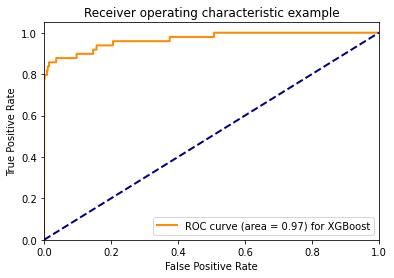

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr_xgb, tpr_xgb, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) for XGBoost' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#Conclusion
- Need more than two weeks, this is especially true for neural network
- Hard to get the neural network to overfit
- Have tried SMOTE and oversampling, but should also try undersampling
- XGBoost is alot simpler to train and optimize
- Should learn more about optimization of neural networks
- Want to learn better optimization techniques (other than randomized grid search or vanilla grid search) 